In [1]:
from src.dataset import CIFARDataset, iid_dataloader, non_iid_dataloader, filter_dataset_by_class
from src.lenet import LeNet, weights_init
from src.train import federated_learning_experiment, train_client
from src.utils import plot_class_distribution
from torchvision import datasets, transforms
from torch.autograd import grad
import os
import numpy as np
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import random

In [2]:
#Setting random seeds
random.seed(41)
np.random.seed(41)
torch.manual_seed(41)

##### Train LeNet on CIFAR-5 and perform iDLG after the first local epoch

Files already downloaded and verified
Files already downloaded and verified


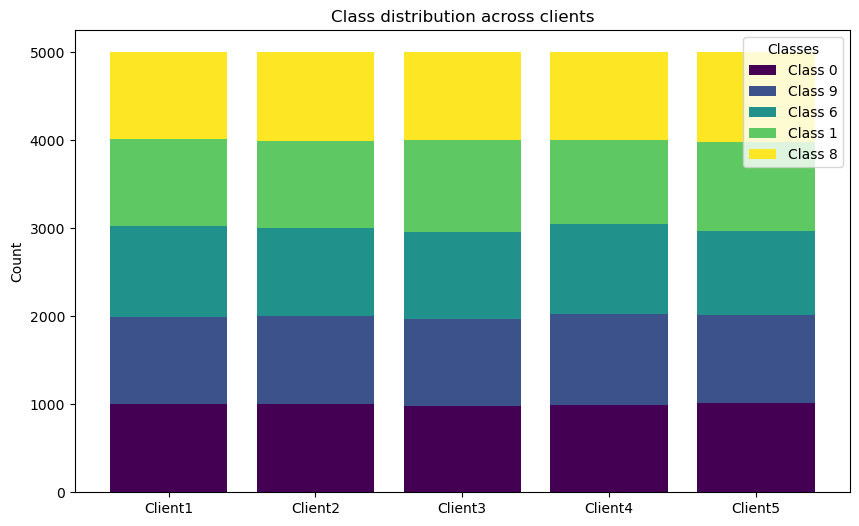

Round 0 is starting
Clients for round 0 are: [1 2 4]
round 0, starting client 1/3, id: 1


Reconstructing training images using iDLG: 100%|██████████| 25/25 [06:24<00:00, 15.38s/it]


Mean squared error: 0.03143774359836243
Label extract accuracy: 100.0 %
Peak Signal-to-Noise-Ratio: 20.78953350664698
Structural Similiarity Index Measure: 4.9166122644293724e-05


Client 1, epoch 0, reconstruction performance using iDLG:


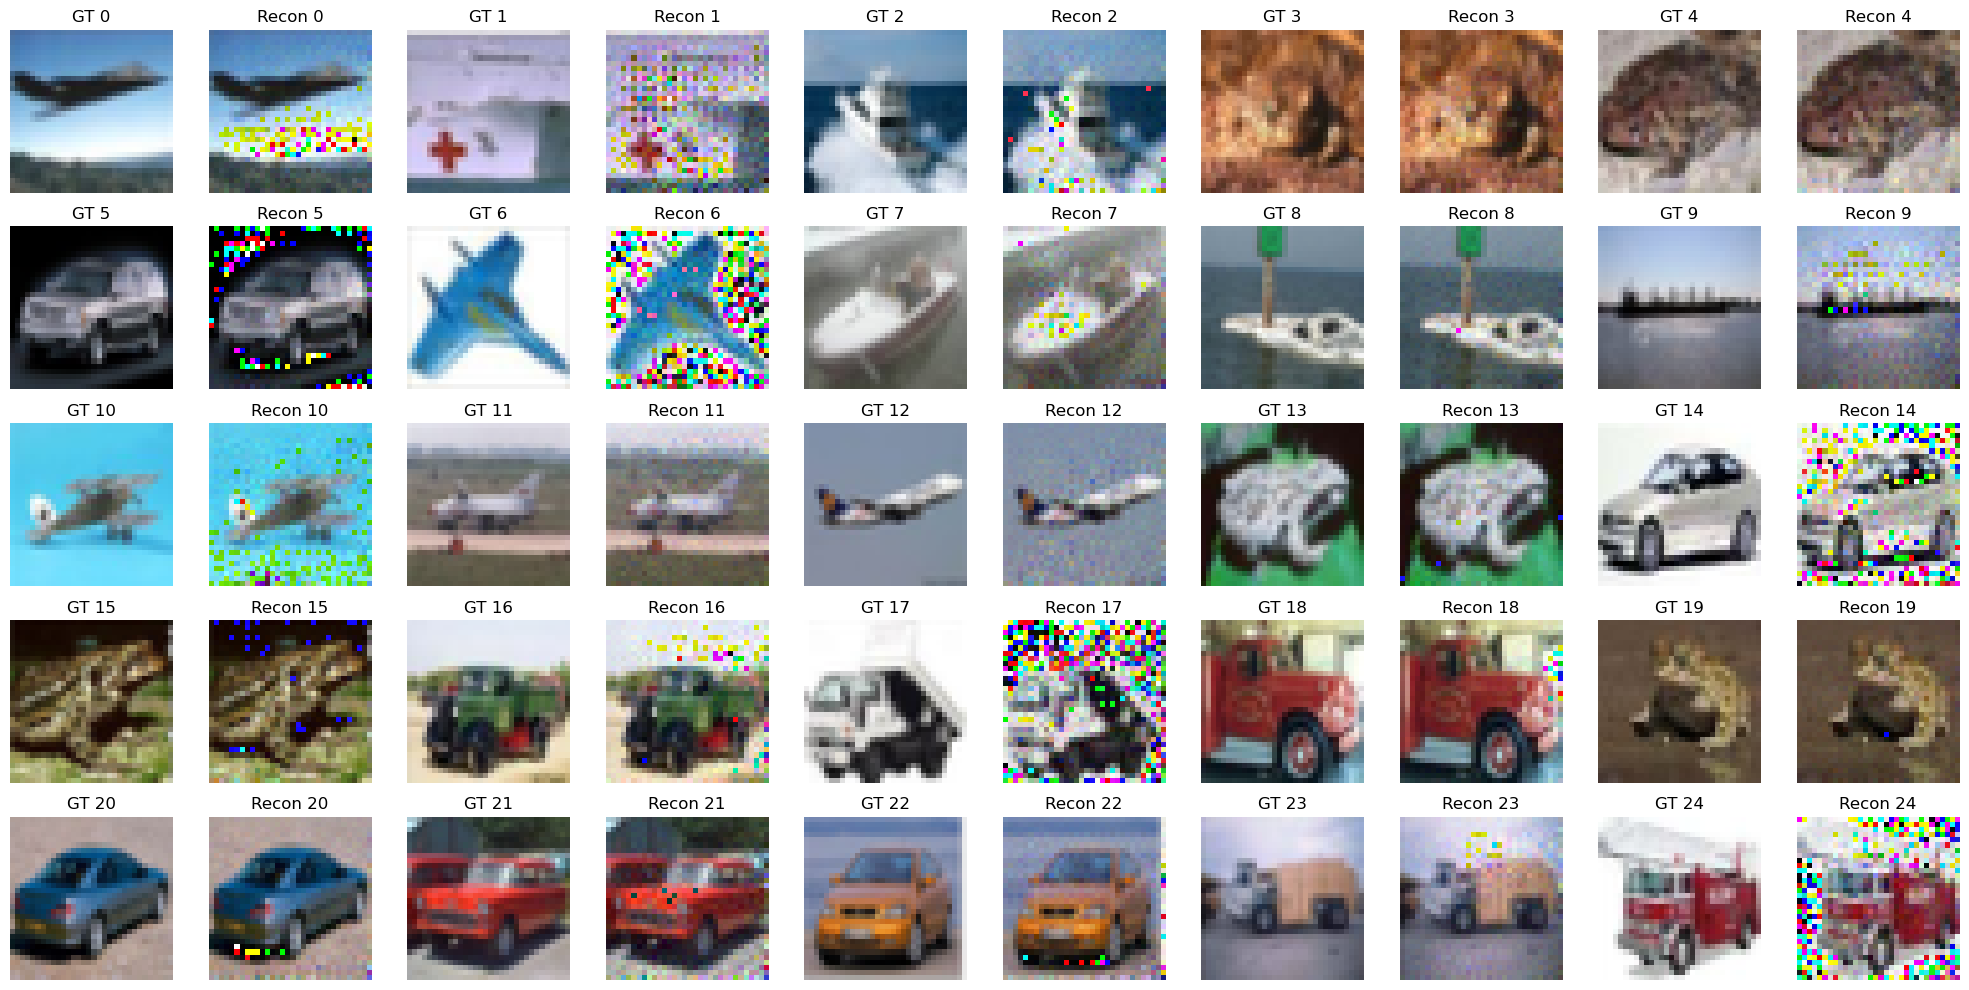

round 0, starting client 2/3, id: 2


Reconstructing training images using iDLG: 100%|██████████| 25/25 [06:23<00:00, 15.35s/it]


Mean squared error: 0.039535383014008406
Label extract accuracy: 100.0 %
Peak Signal-to-Noise-Ratio: 18.074056458998008
Structural Similiarity Index Measure: 4.004303365234776e-05


Client 2, epoch 0, reconstruction performance using iDLG:


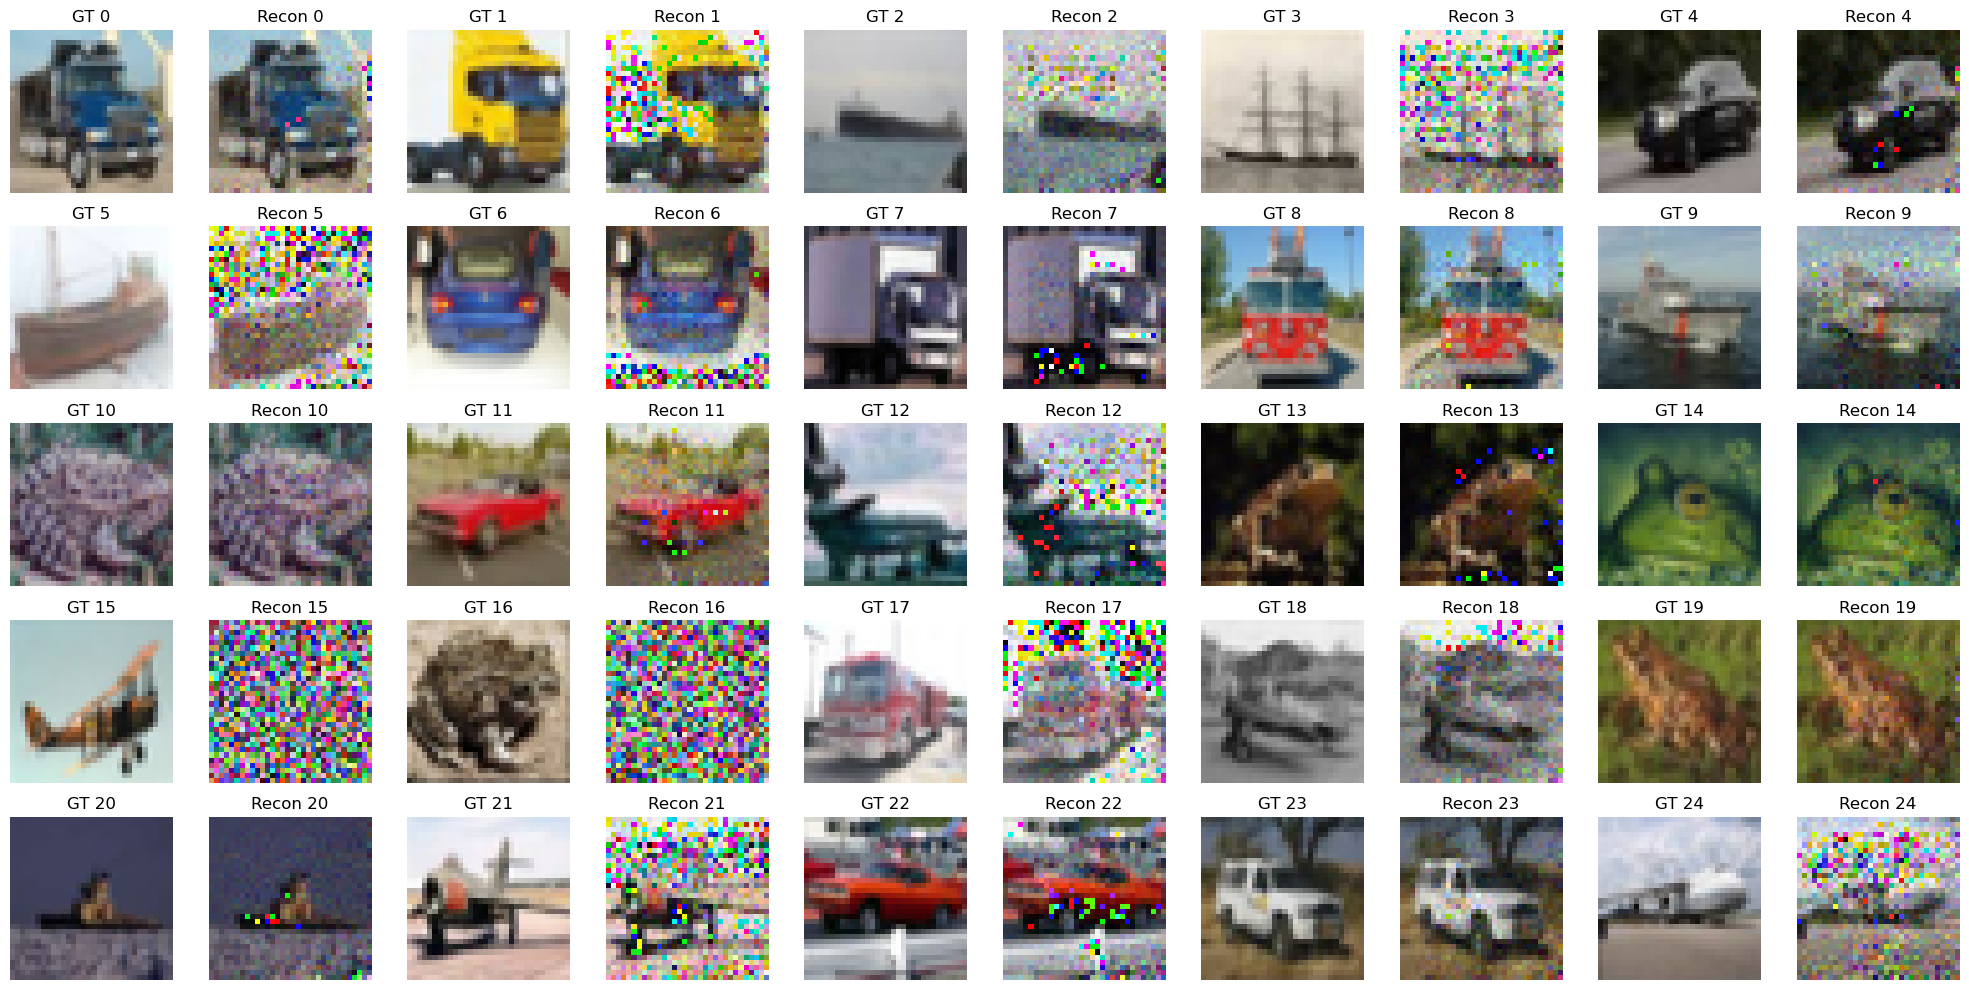

round 0, starting client 3/3, id: 4


Reconstructing training images using iDLG: 100%|██████████| 25/25 [06:32<00:00, 15.70s/it]


Mean squared error: 0.03678612652001902
Label extract accuracy: 100.0 %
Peak Signal-to-Noise-Ratio: 21.373998963653577
Structural Similiarity Index Measure: 4.612473136498712e-05


Client 4, epoch 0, reconstruction performance using iDLG:


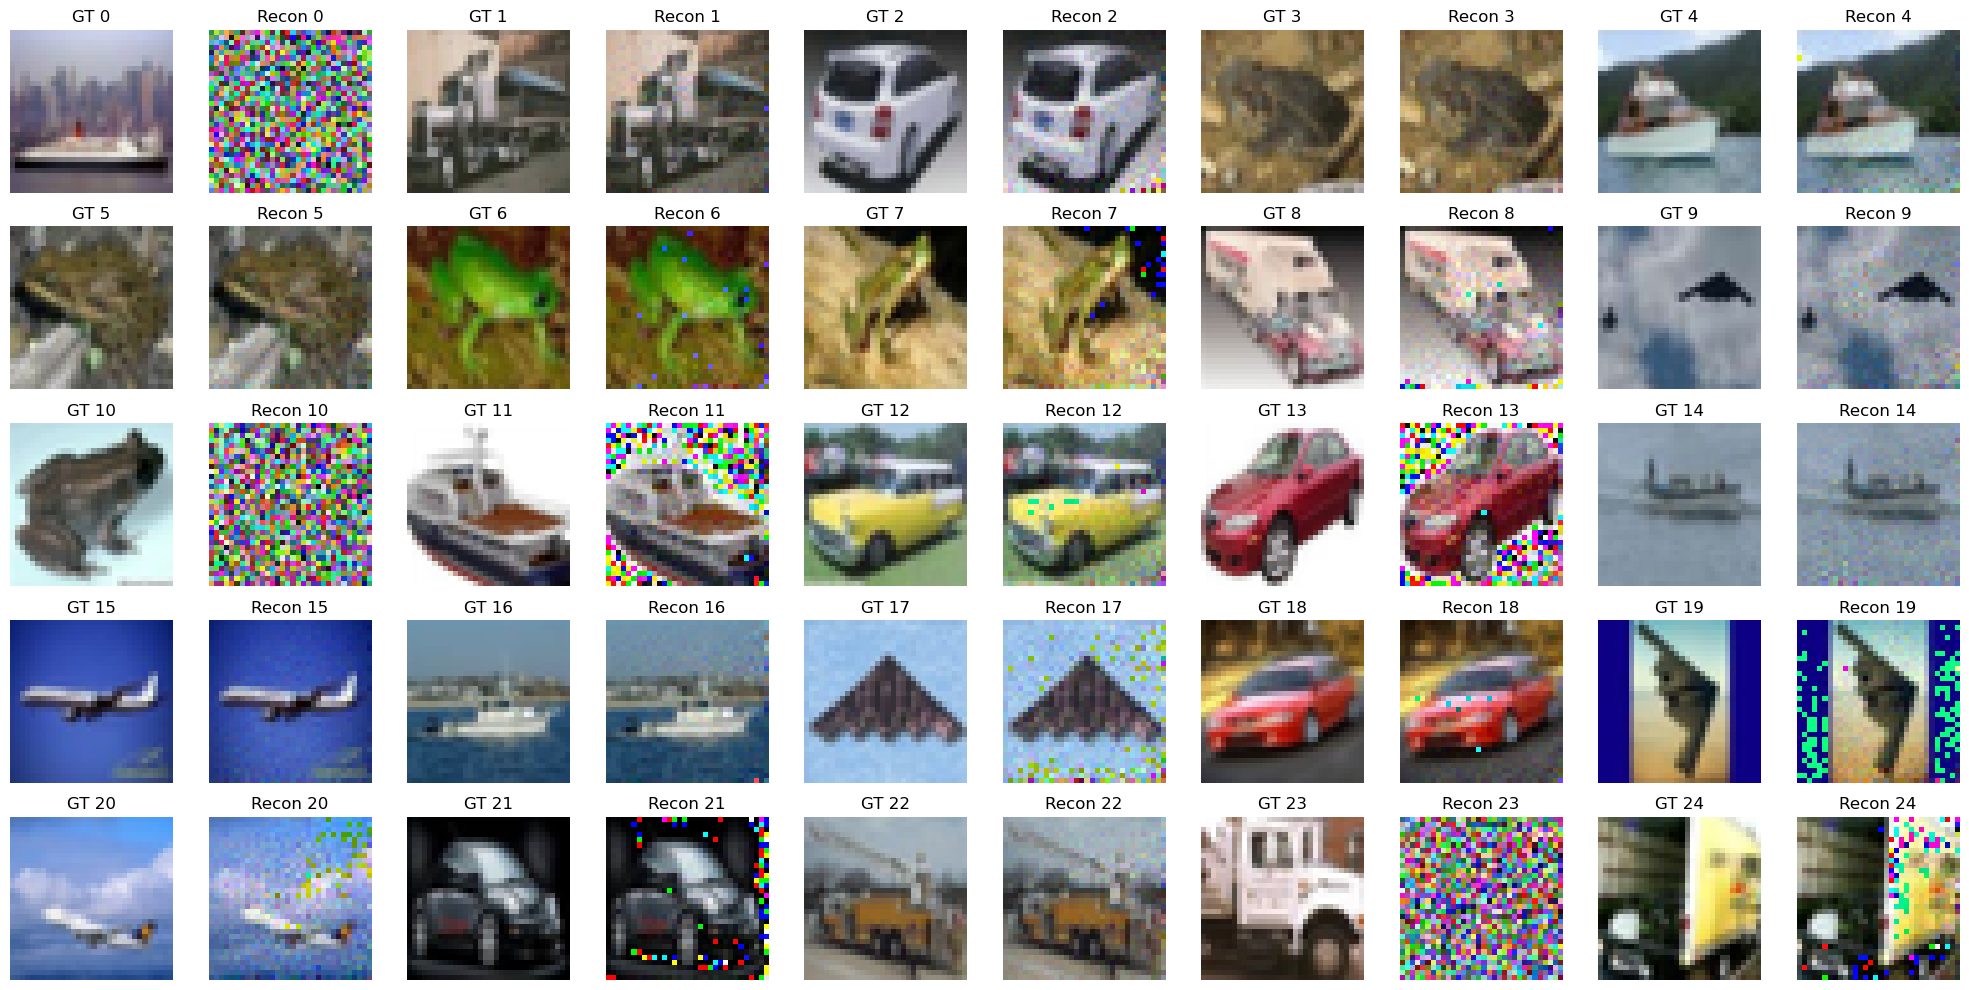

Round 0, validation accuracy: 60.18 %
Round 1 is starting
Clients for round 1 are: [4 2 3]
round 1, starting client 1/3, id: 4
round 1, starting client 2/3, id: 2
round 1, starting client 3/3, id: 3
Round 1, validation accuracy: 69.14 %
Round 2 is starting
Clients for round 2 are: [3 4 0]
round 2, starting client 1/3, id: 3
round 2, starting client 2/3, id: 4
round 2, starting client 3/3, id: 0
Round 2, validation accuracy: 71.22 %
Round 3 is starting
Clients for round 3 are: [1 0 2]
round 3, starting client 1/3, id: 1
round 3, starting client 2/3, id: 0
round 3, starting client 3/3, id: 2
Round 3, validation accuracy: 72.74000000000001 %
Round 4 is starting
Clients for round 4 are: [3 1 2]
round 4, starting client 1/3, id: 3
round 4, starting client 2/3, id: 1
round 4, starting client 3/3, id: 2
Round 4, validation accuracy: 73.0 %
Round 5 is starting
Clients for round 5 are: [4 2 0]
round 5, starting client 1/3, id: 4
round 5, starting client 2/3, id: 2
round 5, starting client 3/3, 

In [3]:
top_5_classes_indices = [0, 9, 6, 1, 8]
device = device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss().to(device)

batch_size = 50
num_clients = 5
cifar_data = CIFARDataset(batch_size=batch_size, num_clients=num_clients, top_5_classes_indices=top_5_classes_indices)
train_dataset, validation_dataset = cifar_data.get_dataset()

non_iid_client_train_loader = iid_dataloader(train_dataset, batch_size=batch_size, num_clients=num_clients)
plot_class_distribution(non_iid_client_train_loader, top_5_classes_indices)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

global_model = LeNet().to(device)
global_model.apply(weights_init)

num_images_per_class = 5

#For each client created a filtered train dataset to be used for iDLG reconstruction:

clients_dataset = {}

for index, client_loader in enumerate(non_iid_client_train_loader):
    client_dataset = client_loader.dataset
    clients_dataset[index] = filter_dataset_by_class(client_dataset, top_5_classes_indices, num_images_per_class)
    
results = federated_learning_experiment(global_model, 
                                        num_clients_per_round=3,
                                        num_local_epochs=10, 
                                        lr = 5e-3, 
                                        client_train_loader=non_iid_client_train_loader, 
                                        max_rounds=10, 
                                        device=device, 
                                        criterion=criterion,
                                        test_dataloader=validation_loader, 
                                        filtered_train_dataset=clients_dataset
                                        )